# Kernelized Classification

Both perceptron and SVM can be kernelized, i.e. the output of the regressor can be passed through the sign function. 

$$ \hat{y} = \text{sign} \left[ \sum_{i=1}^N \alpha_i y_i K(x_i, x) \right] $$ and a perceptron loss applied to the difference between the predictor and the true value. 

The perceptron loss can be posed as:

$$ L(\alpha;x_j, y_j) = \max \left\{0, -\sum_{j=1}^N y_j \alpha_i K(x_i, x_j) \right\} $$ 

The parameters are updated as follows: 
If $\hat{y}(x) \neq y(x)$, set $\alpha \gets \alpha + \eta_t$.  

In [1]:
# Code source: Sebastian Curi and Andreas Krause, based on Jaques Grobler (sklearn demos).
# License: BSD 3 clause

# We start importing some modules and running some magic commands
% matplotlib inline
% reload_ext autoreload
% load_ext autoreload
% autoreload 2

# General math and plotting modules.
import numpy as np
import matplotlib.pyplot as plt

# Project files.
from util import gradient_descent, generate_linear_separable_data, generate_circular_separable_data
import plot_helpers
from kernels import PolynomialKernel, LinearKernel, LaplacianKernel, GaussianKernel, GaussianLinearKernel, PeriodicKernel, PeriodicLinearKernel
from regularizers import L2Regularizer
from classifiers import kNN

# Widget and formatting modules
import ipywidgets
from ipywidgets import interact, interactive, interact_manual
import pylab
# If in your browser the figures are not nicely vizualized, change the following line. 
pylab.rcParams['figure.figsize'] = (10, 5)

# Machine Learning library. 
import sklearn
from sklearn import svm
from sklearn import datasets


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


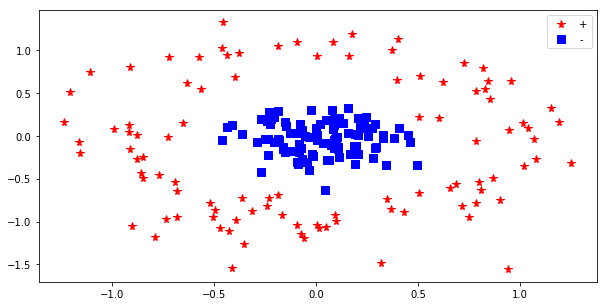

In [2]:
num_points = 100  # Number of points per class
noise = 0.2  # Noise Level (needed for data generation).

X, Y = generate_circular_separable_data(num_points, noise=noise, offset=1)
fig = plt.subplot(111)
opt = {'marker': 'r*', 'label': '+'}
plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'label': '-'}
plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)
fig.legend();


In [3]:
def kernelized_perceptron(eta0, n_iter, batch_size, kernel, deg):
    if kernel == 'Linear':
        classifier = PolynomialKernel(X, Y, reg=0.00, deg=1, prediction=False)
    elif kernel == 'Polynomial':
        classifier = PolynomialKernel(X, Y, reg=0.00, deg=deg, prediction=False)
    elif kernel == 'Gaussian':
        classifier = GaussianKernel(X, Y, reg=0.00, bw=0.2, prediction=False)   
    elif kernel == 'Laplacian':
        classifier = LaplacianKernel(X, Y, reg=0.00, bw=0.2, prediction=False)  
    
    regularizer = L2Regularizer(0.)
    
    alpha0 = 0 * np.random.randn(X.shape[0])

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': None
            }
    alphas, indexes = gradient_descent(alpha0, classifier, regularizer, opts)

    fig = plt.subplot(111)
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-'}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)

    contour_opts = {'n_points': 20, 'x_label': '$x$', 'y_label': '$y$', 'sgd_point': False, 'n_classes': 2}
    opts = {'contour_opts': contour_opts}
    plot_helpers.classification_progression(X, Y, alphas, indexes, classifier, contour_plot=fig, options=opts)

interact_manual(kernelized_perceptron,
                eta0=ipywidgets.FloatSlider(value=0.5,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=20,
                                            min=5,
                                            max=50,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                batch_size=ipywidgets.IntSlider(value=X.shape[0],
                                            min=1,
                                            max=X.shape[0],
                                            step=1,
                                            description='Batch Size:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                kernel=ipywidgets.RadioButtons(
                             options=['Polynomial', 'Gaussian', 'Laplacian'],
                             value='Polynomial',
                             description='Kernel type:',
                             style={'description_width': 'initial'}),
                deg = ipywidgets.IntSlider(
                         value=1,
                         min=1,
                         max=10, 
                         step=1,
                         description='Degree of Polynomial kernel:',
                         style={'description_width': 'initial'}),
               );

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Learning rate:', max=2.0, min=0.1, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=20, continuous_update=False, description='Number of iterations:', max=50, min=5, style=SliderStyle(description_width='initial')), IntSlider(value=200, continuous_update=False, description='Batch Size:', max=200, min=1, style=SliderStyle(description_width='initial')), RadioButtons(description='Kernel type:', options=('Polynomial', 'Gaussian', 'Laplacian'), style=DescriptionStyle(description_width='initial'), value='Polynomial'), IntSlider(value=1, description='Degree of Polynomial kernel:', max=10, min=1, style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## SVM KERNELS
The SVM can also be kernelized! let's look at an example. The actual formulation is not required in the class and discussed in more advanced classes. 

In [5]:
def laplacian_kernel(X, Y, bw):
    """The laplacian kernel is not implemented in SKLEARN, but we can implement it :).
    Because it is not compiled, the running time is a bit longer than other kernels."""
    rows = X.shape[0]
    cols = Y.shape[0]
    K = np.zeros((rows, cols))
    for col in range(cols):
        dist = bw * np.linalg.norm(X - Y[col, :], ord=1, axis=1)
        K[:, col] = np.exp(-dist)
    return K

# Our dataset and targets
n_samples = 200  # Number of points per class
tol = 1e-1

def kernelized_svm(dataset, kernel, reg, bw, deg, noise):
    if dataset is 'blobs':
        X, Y = datasets.make_blobs(n_samples=n_samples, centers=2, random_state=3, cluster_std=10*noise)
    elif dataset is 'circles':
        X, Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=noise, random_state=42)
    elif dataset is 'moons':
        X, Y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=42)
    elif dataset == 'xor':
        np.random.seed(42)
        step = int(n_samples/4)
        
        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)
        
        X[0*step:1*step, :] = noise * np.random.randn(step, 2)
        Y[0*step:1*step] = 1
        X[1*step:2*step, :] = np.array([1, 1]) + noise * np.random.randn(step, 2)
        Y[1*step:2*step] = 1
        
        X[2*step:3*step, :] = np.array([0, 1]) + noise * np.random.randn(step, 2)
        Y[2*step:3*step] = -1
        X[3*step:4*step, :] = np.array([1, 0]) + noise * np.random.randn(step, 2)
        Y[3*step:4*step] = -1
    
    elif dataset == 'periodic':
        np.random.seed(42)
        step = int(n_samples/4)
        
        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)
        
        X[0*step:1*step, :] = noise * np.random.randn(step, 2)
        Y[0*step:1*step] = 1
        X[1*step:2*step, :] = np.array([0, 2]) + noise * np.random.randn(step, 2)
        Y[1*step:2*step] = 1
        
        X[2*step:3*step, :] = np.array([0, 1]) + noise * np.random.randn(step, 2)
        Y[2*step:3*step] = -1
        X[3*step:4*step, :] = np.array([0, 3]) + noise * np.random.randn(step, 2)
        Y[3*step:4*step] = -1
        
    X = X[Y <= 1, :]
    Y = Y[Y <=1 ]
    Y[Y==0] = -1
        
    # Add the 1 feature.  
    X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    plot_support = True
    if kernel == 'poly':
        gamma = 1
        coef0 = 0
    elif kernel == 'sigmoid':
        gamma = np.power(10., bw)
        coef0 = 0
    elif kernel == 'rbf':
        gamma = np.power(10., -bw)
        coef0 = 0
    elif kernel == 'laplacian':
        gamma = np.power(10., -bw)
        coef0 = 0
        kernel = lambda X, Y: laplacian_kernel(X, Y, gamma)
        plot_support = False
    
    classifier = svm.SVC(kernel=kernel, C=np.power(10., -reg), gamma=gamma, degree=deg, coef0=coef0, tol=tol)
    classifier.fit(X, Y)

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure()
    plt.clf()
    fig = plt.axes()
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-'}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)
    
    if plot_support:
        plt.scatter(classifier.support_vectors_[:, 0], classifier.support_vectors_[:, 1], s=80,
                    facecolors='none', edgecolors='k')

    mins = np.min(X, 0)
    maxs = np.max(X, 0)
    x_min = mins[0] - 1
    x_max = maxs[0] + 1
    y_min = mins[1] - 1
    y_max = maxs[1] + 1

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]  
    Xtest = np.c_[XX.ravel(), YY.ravel(), np.ones_like(XX.ravel())]
    # Xtest = np.c_[XX.ravel(), YY.ravel()]
    Z = classifier.decision_function(Xtest)

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    # plt.figure(fignum, figsize=(4, 3))
    plt.contourf(XX, YY, Z > 0, cmap=plt.cm.jet, alpha=0.3)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.99, 0, .99])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

#     plt.xticks(())
#     plt.yticks(())

interact_manual(kernelized_svm, 
        dataset=['blobs', 'circles', 'moons', 'xor', 'periodic'],
        kernel=['poly', 'rbf', 'laplacian'], 
        reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),
        bw=ipywidgets.FloatSlider(value=-1,
                                    min=-3,
                                    max=3,
                                    step=0.1,
                                    readout_format='.1f',
                                    description='Bandwidth 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),  
        deg=ipywidgets.IntSlider(
                         value=1,
                         min=1,
                         max=10, 
                         step=1,
                         description='Degree of Poly:',
                         style={'description_width': 'initial'}),
        noise=ipywidgets.FloatSlider(value=0.05,
                                    min=0.01,
                                    max=0.3,
                                    step=0.01,
                                    readout_format='.2f',
                                    description='Noise level:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),  
        );

interactive(children=(Dropdown(description='dataset', options=('blobs', 'circles', 'moons', 'xor', 'periodic'), value='blobs'), Dropdown(description='kernel', options=('poly', 'rbf', 'laplacian'), value='poly'), FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), FloatSlider(value=-1.0, continuous_update=False, description='Bandwidth 10^:', max=3.0, min=-3.0, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=1, description='Degree of Poly:', max=10, min=1, style=SliderStyle(description_width='initial')), FloatSlider(value=0.05, continuous_update=False, description='Noise level:', max=0.3, min=0.01, step=0.01, style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## KNN

The K-Nearest Neighbors classifier is very easy. The label of a next sample is the label most voted by the $k$ training samples that are closer to this sample.

A simple implementation is $$\hat{y} = \text{sign}\left\{\sum_{i \in \mathcal{N}_k (x)} K(x_i, x) y_i\right\},$$

where $\mathcal{N}_k (x)$ is the set with the $k$ closest neighbours of $x$, $K(x_i, x)$ is a weighting coefficient, and $y_i$ is the label of example $i$. Usually $K(\cdot, \cdot)$ can be a kernel function, that measures the similarity between two points. In the vanilla k-NN method the kernel is just the identity function. 
 


In [6]:
noise = 0.4
X, Y = generate_circular_separable_data(num_points, noise=noise, offset=1)

def change_k_nn(k):
    classifier = kNN(X, Y, k)
    fig = plt.subplot(111)
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-'}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)

    opt = {'n_points': 20, 'x_label': '$x$', 'y_label': '$y$'}
    plot_helpers.plot_classification_boundaries(X, classifier, fig=fig, options=opt)

interact(change_k_nn,
         k=ipywidgets.IntSlider(value=1,
                                min=1,
                                max=9,
                                step=1,
                                description='k',
                                style={'description_width': 'initial'},
                                continuous_update=False)
         );


interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=9, min=1, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))